In [1]:
%load_ext autoreload
%autoreload

from pyDOE import *
from pandas import read_csv,DataFrame
import numpy as np
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import os
from lib_for_paper import *
from pandas.io import wb


data_path="data/"
figures_path="figures_paper_python/"
if not os.path.exists(figures_path):
    os.makedirs(figures_path)

co2_by_sector=read_csv(data_path+"enerdata_emissions_world.csv")
elec_comit=read_csv(data_path+"Future_Power_Sector_Emissions_Committed_ton_CO2.csv")
un_pop=read_csv(data_path+"Total_population_both_sexes_thousands.csv")

scenario_file=read_csv(data_path+"scenarios.csv")

myyears=range(2013,2051)
hist_years=range(1990,2014)

%matplotlib inline

This function gets WRI data directly from the World Bank website

In [2]:
def get_wb_data(data):
    aa = wb.download(indicator=data,start=1990,end=2013,country='all').reset_index()
    out = aa.ix[aa.country=="World",data]
    out.index=range(2013,1989,-1)
    out = out.sort_index(ascending=True)
    return out

In [3]:
hist_emi = get_wb_data("EN.ATM.CO2E.KT")

In [4]:
carb_intens_hist = 1000*get_wb_data("EN.ATM.CO2E.PP.GD.KD")

Here we hardcode missing data on emissions...

In [5]:
hist_emi[2012]=34500000
hist_emi[2013]=36000000
hist_emi[2011]=(hist_emi[2010]+hist_emi[2012])/2

In [7]:
global_emissions_2013_TCO2 = 10**(3)*hist_emi[2013]

In [8]:
hist_gdp = get_wb_data('NY.GDP.MKTP.PP.KD')
GDP_PPP_const_dol_2013 = hist_gdp[2013]

In [9]:
co2_missing=global_emissions_2013_TCO2-10**9*co2_by_sector['2013'].sum()
co2_processes = 2/3*co2_missing
scale_fact = global_emissions_2013_TCO2/(10**9*co2_by_sector['2013'].sum()+co2_processes)
co2_tertiary=10**9*co2_by_sector.loc[2,'2013']*scale_fact
co2_industry=(10**9*co2_by_sector.loc[1,'2013']+co2_processes)*scale_fact
co2_ener=10**9*co2_by_sector.loc[0,'2013']*scale_fact
co2_transport=10**9*co2_by_sector.loc[3,'2013']*scale_fact

#pop 2013
pop_ref=1000*(un_pop.ix[un_pop['year']==2013,'population'].values[0])

# per capita GDP 2013
gdp_pc_ref=GDP_PPP_const_dol_2013/pop_ref

# carbon intensity 2013 (tonCO2/dol)
carb_int_ref=10**(6)*global_emissions_2013_TCO2/GDP_PPP_const_dol_2013

kintref=3.4

In [10]:
carb_int_ref

358.56263862788092

The lines below are for the uncertainty analysis: we load the ranges for the scenarios and then create the scenarios

In [11]:
ranges=read_csv(data_path+"scenarios_ranges.csv")
ranges1=ranges.drop(ranges.index[ranges['variable']=='budget'])

In [12]:
ranges1=ranges1.drop(7)

In [13]:
scenarios=create_scenarios(ranges1,4000)
scenarios["eleclife"] = np.round(scenarios["eleclife"],1)

Elec committed emissions are treated differently because we have precise data from Steve Davis' analysis

In [14]:
if os.path.isfile("elec_scenars_01.csv"):
    elec_scenars = read_csv("elec_scenars_01.csv")
    elec_scenars.index = elec_scenars.eleclife
    elec_scenars = elec_scenars.drop("eleclife",axis=1)
else:
    elec_scenars = create_elec_comit_table(elec_comit,np.round(np.arange(20,60,0.1),1),myyears)

In [15]:
select50 = scenario_file['years']<=2050

rcp26 = 44/12*scenario_file.ix[select50,'RCP 26']
rcp45 = 44/12*scenario_file.ix[select50,'RCP 45']
rcp6 = 44/12*scenario_file.ix[select50,'RCP 6']
rcp85 = 44/12*scenario_file.ix[select50,'RCP 85']
rcp_years = scenario_file.ix[select50,'years']

Here we interpolate the RCPs, which only have emissions data every 5years

In [16]:
from scipy.interpolate import interp1d

rcp26full=interp1d(scenario_file["years"], scenario_file["RCP 26"])
rcp45full=interp1d(scenario_file["years"], scenario_file["RCP 45"])
rcp6full=interp1d(scenario_file["years"], scenario_file["RCP 6"])
rcp85full=interp1d(scenario_file["years"], scenario_file["RCP 85"])

Below is the CO2 budget for each RCP between 2013 and 2050

In [17]:
print(44/12*sum(rcp26full(range(2013,2051))))
print(44/12*sum(rcp45full(range(2013,2051))))
print(44/12*sum(rcp85full(range(2013,2051))))

913.863133333
1479.2745
2032.4293


# first analysis

In [24]:
IC_growth=0
ini_year=2013
budget=915
poprate=0.008
tertlife=50
transplife=15
induslife=47
eleclife=52
GDPgrate=0.03
kintrate=0.01

carb_intens_new_G,carb_intens,remain_e,total_comit=calc_new_intens(budget,GDPgrate,IC_growth,carb_int_ref,gdp_pc_ref,
                                                         poprate,pop_ref,eleclife,myyears,elec_scenars,co2_industry,
                                                         co2_tertiary,co2_transport,induslife,tertlife,transplife,\
                                                                   ini_year,co2_ener,kintrate,kintref)

print(carb_intens_new_G)
print(sum(total_comit))

13.9893393214
831.362052711


In [25]:
for induslife in [10,30,50]:
    for eleclife in [20,40,60]:
        carb_intens_new_G,carb_intens,remain_e,total_comit=calc_new_intens(budget,GDPgrate,IC_growth,carb_int_ref,\
                                                                           gdp_pc_ref,poprate,pop_ref,eleclife,\
                                                                           myyears,elec_scenars,co2_industry,\
                                                         co2_tertiary,co2_transport,induslife,tertlife,transplife,\
                                                                           ini_year,co2_ener,kintrate,kintref)
        print(sum(total_comit))

364.926478113
547.645910652
680.374325995
478.012175685
660.731608224
793.460023567
573.456504436
756.175936976
888.904352318


In [26]:
kintrate=0.01
for GDPgrate in [0.01,0.02,0.03]:
    eleclife=20
    induslife=10
    carb_intens_new_G,carb_intens,remain_e,total_comit=calc_new_intens(budget,GDPgrate,IC_growth,\
                                                                                   carb_int_ref,\
                                                                           gdp_pc_ref,poprate,pop_ref,eleclife,\
                                                                           myyears,elec_scenars,co2_industry,\
                                                         co2_tertiary,co2_transport,induslife,tertlife,transplife,\
                                                                           ini_year,co2_ener,kintrate,kintref)
    print(carb_intens_new_G)

125.114599282
97.2759055148
75.5756244933


Here we run all scenarios with RCP2.6 budget and then RCP4.5

In [30]:
out26=DataFrame(columns=list(scenarios.columns)+['budget','carb_intens_new_G','carb_intens','remain_e'])

IC_growth=0
ini_year=2013
budget=sum(44/12*rcp26full(myyears))
for scenar in scenarios.index:
    [induslife,tertlife,transplife, GDPgrate, poprate,eleclife]=scenarios.loc[scenar,:].values
    carb_intens_new_G,carb_intens,remain_e,total_comit=calc_new_intens(budget,GDPgrate,IC_growth,\
                                                                                   carb_int_ref,\
                                                                           gdp_pc_ref,poprate,pop_ref,eleclife,\
                                                                           myyears,elec_scenars,co2_industry,\
                                                         co2_tertiary,co2_transport,induslife,tertlife,transplife,\
                                                                           ini_year,co2_ener,kintrate,kintref)
    
    out26.loc[len(out26.index)]=list(scenarios.loc[scenar,:].values)+[budget,carb_intens_new_G,carb_intens,remain_e]

out26=out26.astype(float)

In [31]:
out45=DataFrame(columns=list(scenarios.columns)+['budget','carb_intens_new_G','carb_intens','remain_e'])

IC_growth=0
ini_year=2013
budget=sum(44/12*rcp45full(myyears))
for scenar in scenarios.index:
    [induslife,tertlife,transplife, GDPgrate, poprate,eleclife]=scenarios.loc[scenar,:].values
    carb_intens_new_G,carb_intens,remain_e,total_comit=calc_new_intens(budget,GDPgrate,IC_growth,\
                                                                                   carb_int_ref,\
                                                                           gdp_pc_ref,poprate,pop_ref,eleclife,\
                                                                           myyears,elec_scenars,co2_industry,\
                                                         co2_tertiary,co2_transport,induslife,tertlife,transplife,\
                                                                           ini_year,co2_ener,kintrate,kintref)
    
    out45.loc[len(out45.index)]=list(scenarios.loc[scenar,:].values)+[budget,carb_intens_new_G,carb_intens,remain_e]

out45=out45.astype(float)

Decrease compared to today:

In [46]:
0.38/np.percentile(out26['carb_intens_new_G'],[5,95])

array([ 0.02648743,  0.00347871])

Analysis of variance

In [47]:
formula="carb_intens_new_G ~ tertlife + induslife + transplife + GDPgrate + poprate +eleclife"
olsmodel=ols(formula,data=out26).fit()
table=anova_lm(olsmodel)
table['sum_sq_pc']=table['sum_sq']/table['sum_sq'].sum()

In [48]:
table.ix["tertlife","title"] = 'Lifetime of buildings'
table.ix["induslife","title"] = 'Lifetime of industry capital'
table.ix["transplife","title"] = 'Lifetime of transport capital'
table.ix["GDPgrate","title"] = 'GDP growth rate'
table.ix["poprate","title"] = 'Population growth rate'
table.ix["eleclife","title"] = 'Lifetime of energy capital\n(mostly power plants)'
table.ix["Residual","title"] = 'Combination of parameters'

table.ix["tertlife","colors"] = '#8dd3c7'
table.ix["induslife","colors"] = '#ffffb3'
table.ix["transplife","colors"] = '#bebada'
table.ix["GDPgrate","colors"] = '#fb8072'
table.ix["poprate","colors"] = '#80b1d3'
table.ix["eleclife","colors"] = '#fdb462'
table.ix["Residual","colors"] = '#b3de69'

In [49]:
table

,df,sum_sq,mean_sq,F,PR(>F),sum_sq_pc,title,colors
tertlife,1,49593.163501,49593.163501,911.462885,1.564778e-180,0.014964,Lifetime of buildings,#8dd3c7
induslife,1,520100.330833,520100.330833,9558.820505,0.000000e+00,0.156935,Lifetime of industry capital,#ffffb3
transplife,1,62021.012649,62021.012649,1139.871852,4.865486e-220,0.018714,Lifetime of transport capital,#bebada
GDPgrate,1,1281307.334679,1281307.334679,23548.892585,0.000000e+00,0.386621,GDP growth rate,#fb8072
poprate,1,39589.253592,39589.253592,727.603015,2.316462e-147,0.011946,Population growth rate,#80b1d3
eleclife,1,1144243.961412,1144243.961412,21029.832117,0.000000e+00,0.345264,Lifetime of energy capital\n(mostly power plants),#fdb462
Residual,3993,217261.179857,54.410513,NaN,NaN,0.065556,Combination of parameters,#b3de69


In [50]:
olsmodel2=ols(formula,data=out45).fit()
table2=anova_lm(olsmodel2)
table2['sum_sq_pc']=table2['sum_sq']/table2['sum_sq'].sum()
table2.ix["tertlife","title"] = 'Lifetime of buildings'
table2.ix["induslife","title"] = 'Lifetime of industry capital'
table2.ix["transplife","title"] = 'Lifetime of transport capital'
table2.ix["GDPgrate","title"] = 'GDP growth rate'
table2.ix["poprate","title"] = 'Population growth rate'
table2.ix["eleclife","title"] = 'Lifetime of energy capital\n(mostly power plants)'
table2.ix["Residual","title"] = 'Combination of parameters'

table2.ix["tertlife","colors"] = '#8dd3c7'
table2.ix["induslife","colors"] = '#ffffb3'
table2.ix["transplife","colors"] = '#bebada'
table2.ix["GDPgrate","colors"] = '#fb8072'
table2.ix["poprate","colors"] = '#80b1d3'
table2.ix["eleclife","colors"] = '#fdb462'
table2.ix["Residual","colors"] = '#b3de69'

In [51]:
table2

,df,sum_sq,mean_sq,F,PR(>F),sum_sq_pc,title,colors
tertlife,1,1216.412489,1216.412489,8.452238,3.666027e-03,0.000074,Lifetime of buildings,#8dd3c7
induslife,1,83020.136925,83020.136925,576.865161,3.522827e-119,0.005078,Lifetime of industry capital,#ffffb3
transplife,1,15424.441395,15424.441395,107.176683,8.363601e-25,0.000943,Lifetime of transport capital,#bebada
GDPgrate,1,14879479.981190,14879479.981190,103390.020050,0.000000e+00,0.910114,GDP growth rate,#fb8072
poprate,1,496227.139453,496227.139453,3448.032724,0.000000e+00,0.030352,Population growth rate,#80b1d3
eleclife,1,299003.928752,299003.928752,2077.627863,0.000000e+00,0.018289,Lifetime of energy capital\n(mostly power plants),#fdb462
Residual,3993,574656.659667,143.916018,NaN,NaN,0.035149,Combination of parameters,#b3de69


In [52]:
tot_26 = 44/12*sum(rcp26full(range(2013,2100)))
tot_45 = 44/12*sum(rcp45full(range(2013,2100)))

In [53]:
two_deg_50pc = 1100
three_deg_66pc = 2280

In [54]:
sum(44/12*rcp26full(myyears))*two_deg_50pc/tot_26

1047.5961099399356

In [55]:
sum(44/12*rcp45full(myyears))*three_deg_66pc/tot_45

1275.9045484903902

In [56]:
out2C_50=DataFrame(columns=list(scenarios.columns)+['budget','carb_intens_new_G','carb_intens','remain_e'])

IC_growth=0
ini_year=2013
budget=1200
for scenar in scenarios.index:
    [induslife,tertlife,transplife, GDPgrate, poprate,eleclife]=scenarios.loc[scenar,:].values
    carb_intens_new_G,carb_intens,remain_e,total_comit=calc_new_intens(budget,GDPgrate,IC_growth,\
                                                                                   carb_int_ref,\
                                                                           gdp_pc_ref,poprate,pop_ref,eleclife,\
                                                                           myyears,elec_scenars,co2_industry,\
                                                         co2_tertiary,co2_transport,induslife,tertlife,transplife,\
                                                                           ini_year,co2_ener,kintrate,kintref)
    out2C_50.loc[len(out2C_50.index)]=list(scenarios.loc[scenar,:].values)+[budget,carb_intens_new_G,carb_intens,remain_e]

out2C_50=out2C_50.astype(float)

In [57]:
out3C_50=DataFrame(columns=list(scenarios.columns)+['budget','carb_intens_new_G','remain_e'])

IC_growth=0
ini_year=2013
budget=1600
for scenar in scenarios.index:
    [induslife,tertlife,transplife, GDPgrate, poprate,eleclife]=scenarios.loc[scenar,:].values
    carb_intens_new_G,carb_intens,remain_e,total_comit=calc_new_intens(budget,GDPgrate,IC_growth,\
                                                                                   carb_int_ref,\
                                                                           gdp_pc_ref,poprate,pop_ref,eleclife,\
                                                                           myyears,elec_scenars,co2_industry,\
                                                         co2_tertiary,co2_transport,induslife,tertlife,transplife,\
                                                                           ini_year,co2_ener,kintrate,kintref)
    out3C_50.loc[len(out3C_50.index)]=list(scenarios.loc[scenar,:].values)+[budget,carb_intens_new_G,remain_e]

out3C_50=out3C_50.astype(float)

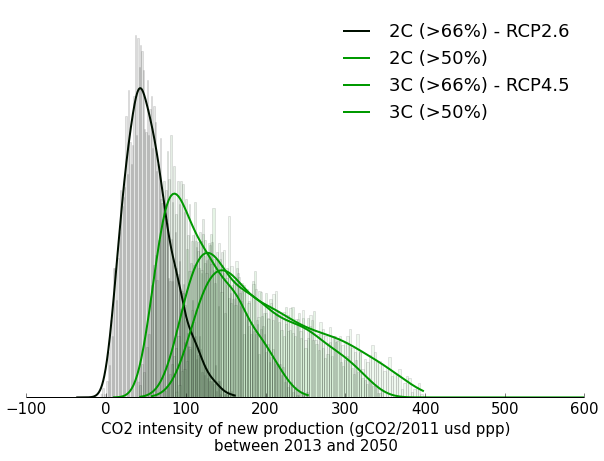

In [60]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(10,7))
ax = plt.subplot(111)

plt.hist(out26['carb_intens_new_G'],bins=100,alpha=0.1,normed=1,color="#000F00")
density = gaussian_kde(out26['carb_intens_new_G'])
xs = np.linspace(out26['carb_intens_new_G'].min()-30,out26['carb_intens_new_G'].max(),600)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs),linewidth=2,color="#000F00",label="2C (>66%) - RCP2.6")
plt.xlabel('CO2 intensity of new production (gCO2/2011 usd ppp)\nbetween 2013 and 2050')

plt.hist(out2C_50['carb_intens_new_G'],bins=100,alpha=0.1,normed=1,color="#005C00")
density3 = gaussian_kde(out2C_50['carb_intens_new_G'])
xs3 = np.linspace(out2C_50['carb_intens_new_G'].min()-30,out2C_50['carb_intens_new_G'].max(),100)
density3.covariance_factor = lambda : .25
density3._compute_covariance()
plt.plot(xs3,density3(xs3),linewidth=2,color="#009900",label="2C (>50%)")

plt.hist(out45['carb_intens_new_G'],bins=100,alpha=0.1,normed=1,color="#009900")
density2 = gaussian_kde(out45['carb_intens_new_G'])
xs2 = np.linspace(out45['carb_intens_new_G'].min()-30,600,200)
density2.covariance_factor = lambda : .25
density2._compute_covariance()
plt.plot(xs2,density2(xs2),linewidth=2,color="#009900",label="3C (>66%) - RCP4.5")

plt.hist(out3C_50['carb_intens_new_G'],bins=100,alpha=0.1,normed=1,color="#66C266")
density4 = gaussian_kde(out3C_50['carb_intens_new_G'])
xs4 = np.linspace(out3C_50['carb_intens_new_G'].min()-30,out3C_50['carb_intens_new_G'].max(),600)
density4.covariance_factor = lambda : .25
density4._compute_covariance()
plt.plot(xs4,density4(xs4),linewidth=2,color="#009900",label="3C (>50%)")

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_ticks([])
ax.xaxis.set_ticks_position('bottom')
ax.spines['top'].set_visible(False)
plt.legend(loc='upper right',frameon=False)
plt.savefig(figures_path+"hist.eps",format='eps')
plt.savefig(figures_path+"hist.png",format='png',dpi=300)

PRIM analysis NOTE: you'll need the EMAworkbench package for those

# Second analysis

In [61]:
def run_scenarios(outall,scenarios,carb_int_ref,gdp_pc_ref,pop_ref,myyears,elec_scenars,co2_industry,co2_tertiary,\
                  co2_transport,co2_ener,ini_year,budget,IC_growth=0):
    outy=DataFrame(columns=list(scenarios.columns)+['ini_year','budget','carb_intens_new_G','carb_intens','remain_e','total_comit'])
    for scenar in scenarios.index:
        [induslife,tertlife,transplife, GDPgrate, poprate,eleclife]=scenarios.loc[scenar,:].values
        carb_intens_new_K,carb_intens,remain_e,total_comit=calc_new_intens(budget,GDPgrate,IC_growth,\
                                                                                   carb_int_ref,\
                                                                           gdp_pc_ref,poprate,pop_ref,eleclife,\
                                                                           myyears,elec_scenars,co2_industry,\
                                                         co2_tertiary,co2_transport,induslife,tertlife,transplife,\
                                                                           ini_year,co2_ener,kintrate,kintref)
        outy.loc[len(outy.index)]=list(scenarios.loc[scenar,:].values)+[ini_year,budget,carb_intens_new_K,carb_intens,remain_e,sum(total_comit)]
    outall=outall.append(outy.astype(float),ignore_index=True)
    return outall

In [62]:
csvname = "all_years_rcp26_ap1.csv"
if os.path.isfile(csvname):
    outall26=read_csv(csvname)
else:
    outall26=DataFrame()
    for ini_year in [2013,2015,2017,2019,2021]:
        outall26 = run_scenarios(outall26,scenarios,carb_int_ref,gdp_pc_ref,pop_ref,myyears,elec_scenars,\
                                 co2_industry,co2_tertiary,co2_transport,co2_ener,ini_year,44/12*sum(rcp26full(myyears)))
    outall26.to_csv(csvname)

In [63]:
csvname = "all_years_rcp45_ap1.csv"
if os.path.isfile(csvname):
    outall45=read_csv(csvname)
else:
    outall45=DataFrame()
    for ini_year in [2013,2015,2017,2019,2021]:
        outall45 = run_scenarios(outall45,scenarios,carb_int_ref,gdp_pc_ref,pop_ref,myyears,elec_scenars,\
                                 co2_industry,co2_tertiary,co2_transport,co2_ener,ini_year,44/12*sum(rcp45full(myyears)))
    outall45.to_csv(csvname)

In [71]:
grouped = outall26.groupby("ini_year")
for i, (name, group) in enumerate(grouped):
    if i>0:
        print(group.carb_intens_new_GDP.min()-prev.carb_intens_new_GDP.min(),\
              group.carb_intens_new_GDP.mean()-prev.carb_intens_new_GDP.mean(),
              group.carb_intens_new_GDP.max()-prev.carb_intens_new_GDP.max())
    prev=group

-52.225175452 -23.6427352056 -22.0895575541
-40.1665819335 -20.8078714323 -13.1833622901
-49.1616538623 -27.7430810534 -16.0405392277
-61.0783877337 -37.2746359692 -20.2804381777


In [72]:
grouped = outall45.groupby("ini_year")
for i, (name, group) in enumerate(grouped):
    if i>0:
        print(group.carb_intens_new_GDP.min()-prev.carb_intens_new_GDP.min(),\
              group.carb_intens_new_GDP.mean()-prev.carb_intens_new_GDP.mean(),
              group.carb_intens_new_GDP.max()-prev.carb_intens_new_GDP.max())
    prev=group

-12.5313012663 -9.95034684977 -12.7866803887
-13.6578465674 -4.66306743164 1.564867968
-21.1148492685 -8.48364648731 1.22291582722
-31.584217308 -13.8820143085 0.715042202362


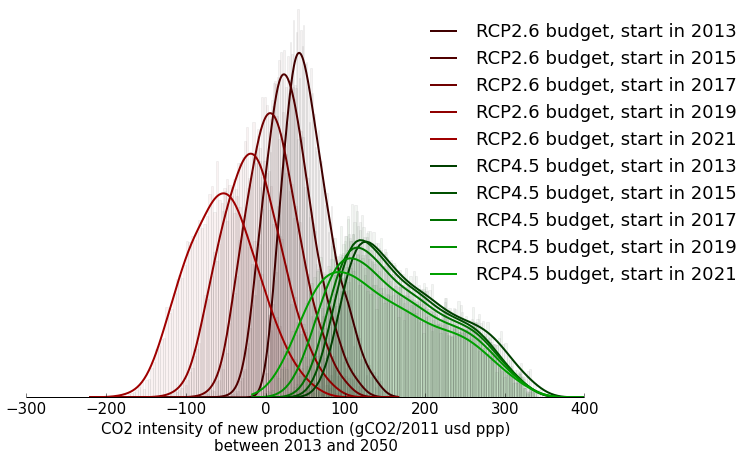

In [67]:
date_list = [2013,2015,2017,2019,2021]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(10,7))
ax = plt.subplot(111)

color_list2=["#004000","#005000","#007000","#009000","#00A000","#00C000","#00E000"]
color_list1=["#400000","#500000","#700000","#900000","#A00000","#C00000","#E00000"]

for ini_year in date_list:
    thecolor=color_list1[date_list.index(ini_year)]
    data=outall26.ix[outall26['ini_year']==ini_year,'carb_intens_new_GDP']
    plt.hist(np.array(data),bins=100,alpha=0.05,normed=1,color=thecolor)
    density = gaussian_kde(data)
    xs = np.linspace(outall26['carb_intens_new_GDP'].min(),outall26['carb_intens_new_GDP'].max(),400)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    strlabel="RCP2.6 budget, start in {}".format(ini_year)
    plt.plot(xs,density(xs),linewidth=2,color=thecolor,label=strlabel)
    
for ini_year in date_list:
    thecolor=color_list2[date_list.index(ini_year)]
    data=outall45.ix[outall45['ini_year']==ini_year,'carb_intens_new_GDP']
    plt.hist(np.array(data),bins=100,alpha=0.05,normed=1,color=thecolor)
    density = gaussian_kde(data)
    xs = np.linspace(outall45['carb_intens_new_GDP'].min()-10,400,100)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    strlabel="RCP4.5 budget, start in {}".format(ini_year)
    plt.plot(xs,density(xs),linewidth=2,color=thecolor,label=strlabel)

plt.legend(bbox_to_anchor=[0.8,0.5,0.5,0.5],frameon=False)
plt.xlabel('CO2 intensity of new production (gCO2/2011 usd ppp)\nbetween 2013 and 2050')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_ticks([])
ax.xaxis.set_ticks_position('bottom')
ax.spines['top'].set_visible(False)
plt.savefig(figures_path+"hist_diff_ini_year.eps",format='eps')
plt.savefig(figures_path+"hist_diff_ini_year.png",format='png',dpi=300)

In [318]:
csvname = "all_budgets_ap1.csv"
if os.path.isfile(csvname):
    outallb=read_csv(csvname)
else:
    outallb=DataFrame()
    for budget in [500,600,700,800,900,1000,1100,1200,1300,1400,1500]:
        outallb = run_scenarios(outallb,scenarios,carb_int_ref,gdp_pc_ref,pop_ref,myyears,elec_scenars,\
                                 co2_industry,co2_tertiary,co2_transport,co2_ener,2013,budget)
    outallb.to_csv(csvname)

In [319]:
csvname = "budgets_real_neg_emissions_june30.csv"
if os.path.isfile(csvname):
    outneg=read_csv(csvname)
else:
    outneg=DataFrame()
    for neg in [0,-5,-10,-15,-20]:
        totnegemissions = neg*25
        by2050 = sum(rcp26full(range(2013,2051)))-(totnegemissions-sum(traj[traj<0]))*(2050-2013)/(2075-2013)
        budget = by2050*44/12
        outneg = run_scenarios(outneg,scenarios,carb_int_ref,gdp_pc_ref,pop_ref,myyears,elec_scenars,\
                                 co2_industry,co2_tertiary,co2_transport,co2_ener,2013,budget)
        outneg.ix[outneg["budget"]==budget,"negative_rate"] = neg
    outneg.to_csv(csvname)

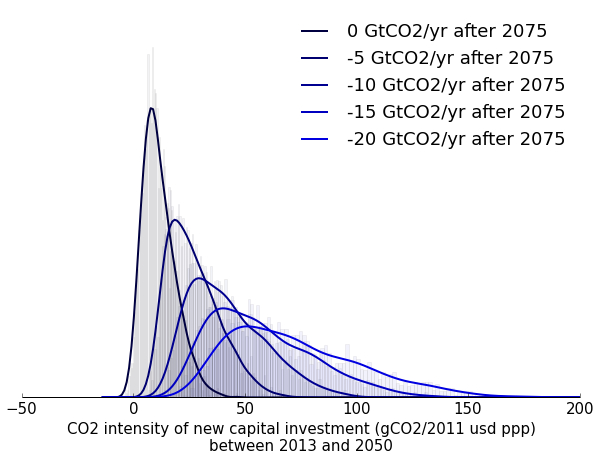

In [320]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(10,7))
ax = plt.subplot(111)

color_list=["#000040","#000070","#000090","#0000C0","#0000E0"]
neg_list = [0,-5,-10,-15,-20]

for neg in neg_list:
    thecolor=color_list[neg_list.index(neg)]
    data=outneg.ix[outneg['negative_rate']==neg,'carb_intens_new_K']
    plt.hist(np.array(data),bins=100,alpha=0.05,normed=1,color=thecolor)
    density = gaussian_kde(data)
    xs = np.linspace(outneg['carb_intens_new_K'].min()-10,200,200)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    strlabel="{} GtCO2/yr after 2075".format(neg)
    plt.plot(xs,density(xs),linewidth=2,color=thecolor,label=strlabel)

plt.legend(loc='upper right',frameon=False)
plt.xlabel('CO2 intensity of new capital investment (gCO2/2011 usd ppp)\nbetween 2013 and 2050')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_ticks([])
ax.xaxis.set_ticks_position('bottom')
ax.spines['top'].set_visible(False)
plt.savefig(figures_path+"hist_NET.eps",format='eps')
plt.savefig(figures_path+"hist_NET.png",dpi=300)

In [324]:
from pandas import cut,get_dummies

In [325]:
out900 = outallb.ix[outallb.budget==900,:]
out900["mean_lifetime"] = (out900.eleclife+out900.induslife)/2

C:\Miniconda3\lib\site-packages\IPython\kernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [326]:
mean_lifetime = get_dummies(cut(out900.mean_lifetime,[10,20,30,40,50,60]))

In [327]:
mycolors = ["#1a9641","#a6d96a","#ffffbf","#fdae61","#d7191c"]
groups = list(mean_lifetime.columns)

In [329]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

cMap = []
for value, colour in zip([0,1,2,3,4],["#1a9641","#a6d96a","#ffffbf","#fdae61","#d7191c"]):
    cMap.append((value/4, colour))
colorMap2 = LinearSegmentedColormap.from_list("custom", cMap)

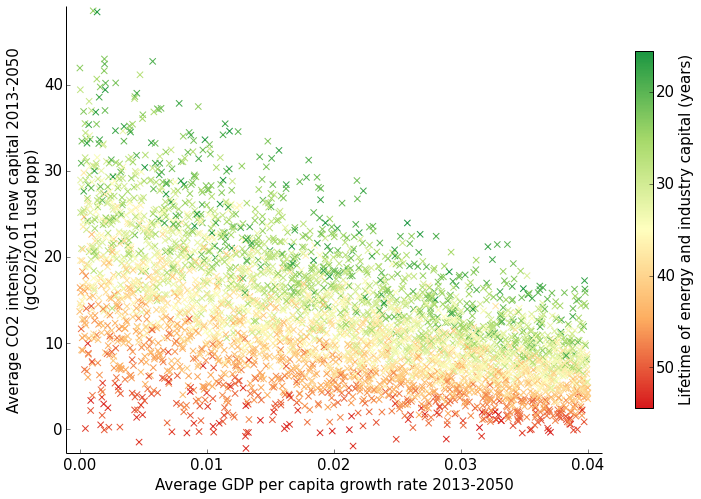

In [330]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
fig = plt.figure(figsize=(12,8))
ax1=plt.subplot(111)
#l = ax1.scatter(out26["GDPgrate"],out26["carb_intens_new_GDP"],c=out26["eleclife"],\
#                marker="o",cmap='Greens',alpha=0.5,edgecolor='grey',s=40)
l = ax1.scatter(out900["GDPgrate"],out900["carb_intens_new_K"],c=(out900.eleclife+out900.induslife)/2,
                marker="x",s=40,cmap=colorMap2)
#cb = fig.colorbar(l,shrink=0.8)
cb = fig.colorbar(l,shrink=0.8,ticks=[20,30,40,50,60])
cb.ax.invert_yaxis()
#cb.ax.set_yticklabels([str(i) for i in range(20,70,10)])# vertically oriented colorbar
cb.set_label("Lifetime of energy and industry capital (years)")


#ax1.scatter(out45["GDPgrate"],out45["carb_intens_new_GDP"],color="red",marker="+")
ax1.margins(0.01)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
plt.ylabel("Average CO2 intensity of new capital 2013-2050\n(gCO2/2011 usd ppp)")
plt.xlabel("Average GDP per capita growth rate 2013-2050")
plt.savefig(figures_path+"carb_intens_explained.eps",format='eps',bbox_inches="tight")
plt.savefig(figures_path+"carb_intens_explained_option1.png",format='png',bbox_inches="tight",dpi=300)

In [332]:
anova_all=DataFrame(columns=['tertlife', 'induslife', 'transplife', 'GDPgrate', 'poprate','eleclife','kintrate'])
for budget in outallb.budget.unique():
    out = outallb.ix[outallb.budget==budget,:]

    formula="carb_intens_new_K ~ tertlife + induslife + transplife + GDPgrate + poprate +eleclife+kintrate"
    olsmodel=ols(formula,data=out).fit()
    table=anova_lm(olsmodel)
    table['sum_sq_pc']=100*table['sum_sq']/table['sum_sq'].sum()    
    tablet=table.transpose()
    inter=tablet.loc[['sum_sq_pc']]
    inter.index=[budget]
    anova_all=anova_all.append(inter)

In [336]:
anova_all.rename(columns={"tertlife":'Lifetime of buildings',"induslife":'Lifetime of industry capital',"transplife":\
                         'Lifetime of transport capital',"GDPgrate":'GDP growth rate',"poprate":'Population growth rate',\
                         "eleclife":'Lifetime of energy capital\n(mostly power plants)',"Residual":\
                          'Combination of parameters',"kintrate":"Capital intensity of GDP"},inplace=True)

In [337]:
anova_all[800:1600]

,GDP growth rate,Combination of parameters,Lifetime of energy capital (mostly power plants),Lifetime of industry capital,Capital intensity of GDP,Population growth rate,Lifetime of buildings,Lifetime of transport capital
800,12.006527,11.360515,45.509984,22.350135,3.840981,0.421324,1.759569,2.750966
900,31.365203,8.410939,31.221563,15.320448,9.465560,1.039257,1.229266,1.947765
1000,47.629184,6.467337,19.002902,9.315638,14.047636,1.542914,0.764362,1.230027
1100,57.996164,5.495914,11.107191,5.438563,16.896601,1.856201,0.458328,0.751039
1200,64.025601,5.088697,6.451756,3.154463,18.511244,2.033835,0.274619,0.459784
1300,67.473473,4.959912,3.747843,1.829066,19.406645,2.132396,0.165794,0.284872
1400,69.456392,4.960827,2.162704,1.052936,19.901491,2.186907,0.100489,0.178253
1500,70.603368,5.019623,1.222442,0.593220,20.172095,2.216748,0.060602,0.111901


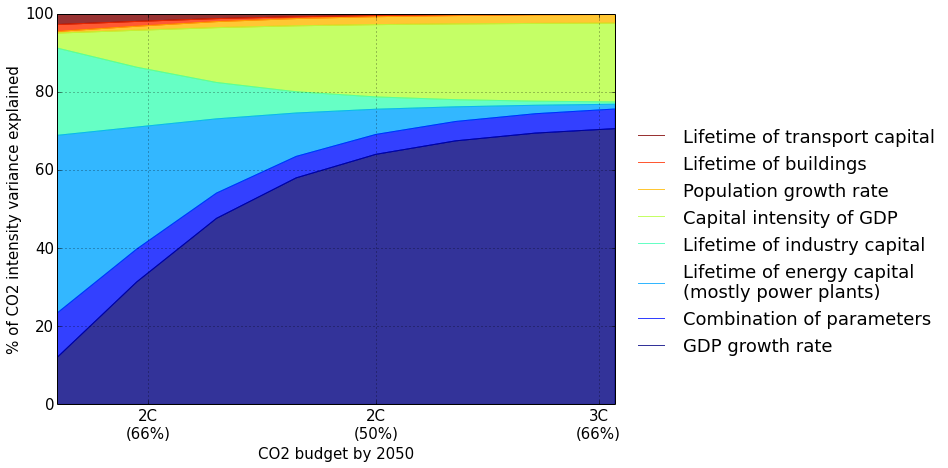

In [338]:
f1 = plt.figure(figsize=(10,7))
anova_all[800:1500].plot(ylim=(0,100),sort_columns=False,kind='area',colormap="jet",ax=f1.gca(),alpha=0.8)
#.legend(bbox_to_anchor=(1.6, 0.75),frameon=False)
ax=f1.gca()
#plt.xticks(anova_all.index,np.round(2.2/1000*12/44*(np.array(anova_all.index)+1900),2))
handles, labels = ax.get_legend_handles_labels()
#l = ax.get_legend()
ax.legend(handles[::-1],labels[::-1],bbox_to_anchor=(1.6, 0.75),frameon=False)
plt.ylabel('% of CO2 intensity variance explained')
ax.set_xlabel('CO2 budget by 2050')

ax.set_xticks(np.array([sum(44/12*rcp26full(myyears)),1200,\
                        sum(44/12*rcp45full(myyears))]))

ax.set_xticklabels(['2C\n(66%)','2C\n(50%)',\
                        '3C\n(66%)'])

plt.savefig(figures_path+"anova_all_budgets.eps",format='eps',bbox_inches="tight")
plt.savefig(figures_path+"anova_all_budgets.png",format='png',dpi=300,bbox_inches="tight")